In [27]:
%pip -r install requirements.txt


Usage:   
  /home/chieh-chiyang/anaconda3/envs/habitat/bin/python -m pip <command> [options]

no such option: -r
Note: you may need to restart the kernel to use updated packages.


In [28]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler
from efficientnet_pytorch import EfficientNet
import time


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [30]:
# Create the dic: name of class to index
# ex : 001.Black_footed_Albatross to 0
#      ...                        to .
#      200.Common_Yellowthroat    to 199

fh = open('2021VRDL_HW1_datasets/classes.txt')
dic = {}
idx = 0
for line in fh.readlines():
    cls = line.split()
    dic[cls.pop(0)] = idx
    idx += 1
Counter = [0] * 200


In [31]:
# the data in training_labels.txt has 15 imgs for each class (uniformly)
# there are 200 classes
# Spilt the training_labels.txt to train and val
# train is 14 x 200
# val is 1 x 200

fh = open('2021VRDL_HW1_datasets/training_labels.txt')
train = []
val = []
for line in fh.readlines():

    cls = line.split()
    image_name = cls.pop(0)  # image name
    # print(cls.pop(0))
    label = cls.pop(0)
    label_id = dic[label]
    Counter[label_id] = Counter[label_id] + 1
    # there are 15 for each class
    if(Counter[label_id] == 5):
        val.append([image_name, label])
    else:
        train.append([image_name, label])

np.savetxt('2021VRDL_HW1_datasets/train_data.txt', train, fmt='%s')
np.savetxt('2021VRDL_HW1_datasets/val_data.txt', val, fmt='%s')


In [32]:

class BirdDataset(Dataset):

    def __init__(self, root, transform):

        self.transform = transform  # 影像的轉換方式

        fh = open('2021VRDL_HW1_datasets/classes.txt')
        d = {}
        idx = 0
        for line in fh.readlines():
            cls = line.split()
            d[cls.pop(0)] = idx
            idx = idx + 1

        fh = open(root)
        labels = []
        imgs = []
        for line in fh.readlines():
            cls = line.split()
            # image name
            imgs.append('2021VRDL_HW1_datasets/training_images/'+cls.pop(0))
            label = d[cls.pop(0)]
            labels.append(label)  # image label

        self.filenames = imgs  # 資料集的所有檔名
        self.labels = labels  # 影像的標籤
        assert len(self.filenames) == len(self.labels), 'mismatched length!'

    def __len__(self):

        return len(self.filenames)  # return DataSet 長度

    def __getitem__(self, idx):

        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image)  # Transform image
        label = np.array(self.labels[idx])

        return image, label  # return 模型訓練所需的資訊


In [33]:
batch_size = 8
lr = 1e-3
epochs = 1
image_size = 456


In [34]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transformer = transforms.Compose([
    transforms.Resize((image_size)),
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomErasing(inplace=True),
    normalize
])
val_transformer = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    normalize
])
test_transformer = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    normalize
])
# 14 * 20 = 2800
# create dataset
training_set = BirdDataset(
    root='2021VRDL_HW1_datasets/train_data.txt', transform=data_transformer)
train_dataloader = torch.utils.data.DataLoader(
    training_set, batch_size=batch_size, shuffle=True, pin_memory=True)

# 1 * 20 = 200
# create dataset
val_set = BirdDataset(
    root='2021VRDL_HW1_datasets/val_data.txt', transform=val_transformer)
val_dataloader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size*2, shuffle=True, pin_memory=True)


# efficientnet
## pretrain model

In [35]:
from efficientnet_pytorch import EfficientNet
C = EfficientNet.from_pretrained('efficientnet-b5', num_classes=200)
optimizer_C = optim.SGD(C.parameters(), lr = lr, momentum=0.9, weight_decay= 1e-4) # 選擇你想用的 optimizer#torch.
#optimizer_C = optim.Adam(C.parameters(), lr = lr,  weight_decay= 1e-4)
criteron = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer_C, gamma = 0.1, last_epoch=-1)
C = C.cuda()
#summary(C, (3, 300, 300)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)

Loaded pretrained weights for efficientnet-b5


# Resnet-50

In [36]:
"""
C = models.resnet50(pretrained=True).to(device)
optimizer_C = optim.SGD(C.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_C, step_size, gamma=0.1, last_epoch=-1)
num_ftrs = C.fc.in_features
C.fc = nn.Linear(num_ftrs, 200)
C = C.cuda()
summary(C, (3, 224, 224))
criteron = nn.CrossEntropyLoss()

"""

'\nC = models.resnet50(pretrained=True).to(device)\noptimizer_C = optim.SGD(C.parameters(), lr=lr, momentum=0.9)\nlr_scheduler = optim.lr_scheduler.StepLR(\n    optimizer_C, step_size, gamma=0.1, last_epoch=-1)\nnum_ftrs = C.fc.in_features\nC.fc = nn.Linear(num_ftrs, 200)\nC = C.cuda()\nsummary(C, (3, 224, 224))\ncriteron = nn.CrossEntropyLoss()\n\n'

In [37]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0


In [38]:
if __name__ == '__main__':

    for epoch in range(epochs):

        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss_C = 0.0

        C.train()  # 設定 train 或 eval

        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))

        # ---------------------------
        # Training Stage
        # ---------------------------

        start = time.time()
        for i, (x, label) in enumerate(train_dataloader):

            x, label = x.to(device), label.to(device)
            optimizer_C.zero_grad()  # 清空梯度

            output = C(x)  # 將訓練資料輸入至模型進行訓練
            loss = criteron(output, label)  # 計算 loss

            loss.backward()  # 將 loss 反向傳播
            optimizer_C.step()  # 更新權重
            # lr_scheduler.step()

            # 計算訓練資料的準確度 (correct_train / total_train)
            _, predicted = torch.max(output.data, 1)
            total_train += label.size(0)
            correct_train += (predicted == label).sum()
            train_loss_C += loss.item()
            iter += 1
        end = time.time()
        print('Training epoch: %d / loss_C: %.3f | acc: %.3f | time:%.3f' %
              (epoch + 1, train_loss_C / iter,
               correct_train / total_train, end-start))

        #  --------------------------
        #  Testing Stage
        #  --------------------------

        C.eval()  # 設定 train 或 eval

        start = time.time()
        for i, (x, label) in enumerate(val_dataloader):

            with torch.no_grad():  # 測試階段不需要求梯度
                x, label = x.to(device), label.to(device)

                output = C(x)  # 將測試資料輸入至模型進行測試
                # 計算測試資料的準確度
                _, predicted = torch.max(output.data, 1)
                total_test += label.size(0)
                correct_test += (predicted == label).sum()
        end = time.time()
        print('Testing acc: %.3f | time:%.3f' % (
            correct_test / total_test, end-start))

        train_acc.append(100 * (correct_train / total_train))
        test_acc.append(100 * (correct_test / total_test))
        loss_epoch_C.append(train_loss_C / iter)  # loss
        
    torch.save(C, 'model_save/'+str(epoch)+'.pth')


epoch: 1 / 1
Training epoch: 1 / loss_C: 5.271 | acc: 0.012 | time:119.281
Testing acc: 0.100 | time:1.938


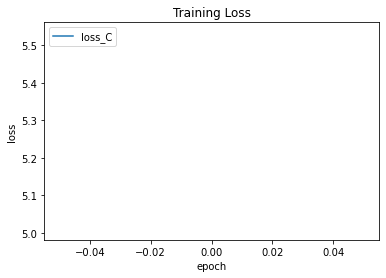

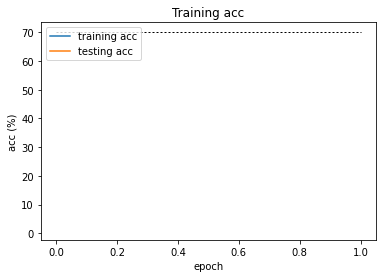

In [39]:
plt.figure()

plt.plot(loss_epoch_C)  # plot your loss

plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_C'], loc='upper left')
plt.savefig('Loss.png')
plt.show()

plt.figure()

plt.plot(train_acc, label="train")  # plot your training accuracy
plt.plot(test_acc, label="test")  # plot your testing accuracy
plt.plot([0, epochs], [70, 70], 'k-', lw=1, dashes=[2, 2])

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc='upper left')
plt.savefig('Acc.png')
plt.show()


## load the model and define the testset loader

In [40]:
class Bird_test_Dataset(Dataset):

    def __init__(self, root, transform, is_train=True):

        self.transform = transform

        fh = open('2021VRDL_HW1_datasets/classes.txt')
        d = {}
        idx = 0
        for line in fh.readlines():
            cls = line.split()
            d[cls.pop(0)] = idx
            idx = idx + 1

        if is_train is True:
            fh = open(root)
            labels = []
            imgs = []
            for line in fh.readlines():
                cls = line.split()
                imgs.append(
                    '2021VRDL_HW1_datasets/training_images/' + cls.pop(0))

                label = d[cls.pop(0)]
                labels.append(label)  # image label

            self.filenames = imgs  # 資料集的所有檔名
            self.labels = labels  # 影像的標籤
            assert len(self.filenames) == len(self.labels), 'mismatched'
        else:
            fh = open(root)
            labels = []
            imgs = []
            for line in fh.readlines():
                cls = line.split()
                # image name
                imgs.append('2021VRDL_HW1_datasets/testing_images/'+cls.pop(0))

            self.filenames = imgs  # 資料集的所有檔名

    def __len__(self):

        return len(self.filenames)  # return DataSet 長度

    def __getitem__(self, idx):

        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image)  # Transform image

        return self.filenames[idx], image  # return 模型訓練所需的資訊


model = torch.load('model_save/0.pth')
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [42]:
submission = []

fh = open('2021VRDL_HW1_datasets/classes.txt')
dic = []

for line in fh.readlines():
    cls = line.split()
    dic.append(cls.pop(0))

fh = open('2021VRDL_HW1_datasets/testing_img_order.txt')
test_imgs = []

for line in fh.readlines():
    cls = line.split()
    test_imgs.append(cls.pop(0))

testdata = Bird_test_Dataset(
    root='2021VRDL_HW1_datasets/testing_img_order.txt',
    transform=test_transformer, is_train=False)
test_dataloader = torch.utils.data.DataLoader(testdata, batch_size=1)

for i, (image_name, x) in enumerate(test_dataloader):
    # print(test_imgs[i])
    with torch.no_grad():  # 測試階段不需要求梯度
        x = x.to(device)

        output = model(x)  # 將測試資料輸入至模型進行測試

        # print(output)
        _, predicted = torch.max(output.data, 1)
        predict_label = dic[int(predicted[0])]
        submission.append([test_imgs[i], predict_label])

print(len(submission))
np.savetxt('answer.txt', submission, fmt='%s')


3033
